# Foreword

This script performs a flood risk assessment for the Awash, Omo and Rift Valley basins in Ethiopia. The metric provided as output is the annual average population and buildings affected per Woreda, for fluvial and pluvial flooding separately.

The flood risk assessment is performed in multiple steps, as explained below:

1.	**Definition of the Area of Interest (AOI)**: The polygons of the basins of the Awash, Omo and Rift Valley Rivers are identified.

2.	**Definition of the hazard, exposure and vulnerability datasets**: The global databases of flood hazard, exposure and vulnerability are identified. The polygon of the AOI is used to clip the global databases to the AOI.

3.	**Computation of the flood risk at AOI level**: The hazard, exposure and vulnerability datasets for the AOI are overlaid to compute the overall absolute flood risk and the spatial distribution of the flood risk across the AOI. The flood risk metric provided is the Annual Average affected population and buildings.

4.	**Computation of the flood risk at Woreda level**: The computed flood risk in step 3 is disaggregated at Woreda level, overlaying the flood risk layer for the entire AOI with a layer of polygons of the Woredas.

The inputs used in this script are:

- **River basins**: The polygons of the main Ethiopian river basins provided in the Data Catalogue of the World Bank are used.
- **Administrative boundaries**: The polygons of the Woredas (administrative level 3) provided by the Ethiopian GeoPortal are used to disaggregate the flood risk assessment at district level. Ethiopia is divided in 684 Woredas (Ethiopia GeoPortal, 2020), and approximately 300 of them intersect the AOI of this project.
- **Flood hazard**: The Global Flood Map from Fathom is used as flood hazard input. This source includes a set of rasters that provide the maximum flood depth for different return periods and flood types worldwide. The rasters have an horizontal resolution of 30 meters. For this study, the global rasters for fluvial and pluvial flooding for 5, 10, 20, 50 , 100, 200, 500 and 1000-year return periods are clipped to the river basins of interest to perform the flood hazard assessment.
- **Flood exposure**: WorldPop population and building counts rasters are used to identify the exposure at the area of interest. These layers provide the number of people and buildings for a grid of 100-meter horizontal resolution, respectively. For population counts, the estimated population by WorldPop using constrained methods and adjusted to UN estimates is used. For building counts, the Ethiopian subset from the gridded maps of building patterns throughout sub-Saharan Africa (version 1.1) is used.
- **Flood vulnerability**: The vulnerability of buildings and population to floods is simplified, by assuming a one-step vulnerability function. It is assumed that population and building are affected if the flood depth affecting them exceeds 50 cm.

In [196]:
from IPython.display import Image, display

image_path = '/Users/aprida/Desktop/flow_chart_methodology.png'  # Replace with the actual image filename
display(Image(filename=image_path))

# Import packages

In [1]:
import boto3
import geopandas as gpd
import os
import rasterio as rio
from rasterio.features import shapes
from rasterio.merge import merge
import rioxarray as rxr
import xarray as xr
import pandas as pd
from rioxarray.merge import merge_arrays
from osgeo import gdal
import numpy as np
from shapely.geometry import Polygon, box, shape, MultiPolygon
from geoalchemy2 import Geometry
import matplotlib.pyplot as plt
import contextily as cx
import shutil
import warnings
from sqlalchemy import create_engine, text
from datetime import datetime
import glob
import requests
from shapely.geometry import shape
from shapely import wkt
import io
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as path_effects

warnings.filterwarnings('ignore')

In [2]:
root = '/Users/aprida/Documents/Consulting/Public_sector/WB_Ethiopia'

# Functions

In [3]:
# Get list of folders of the Fathom Global Flood Maps from S3
def get_s3_folder_list(bucket_name, prefix, include_pattern, exclude_pattern):
    s3_client = boto3.client('s3')
    paginator = s3_client.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket_name, Prefix=prefix, Delimiter='/')

    folders = []
    include_regex = re.compile(include_pattern)
    exclude_regex = re.compile(exclude_pattern)
    
    for page in page_iterator:
        for common_prefix in page.get('CommonPrefixes', []):
            folder_name = common_prefix['Prefix'].strip('/')
            if include_regex.match(folder_name) and not exclude_regex.match(folder_name):
                folders.append(folder_name)
    
    return folders

# Generate Fathom tiles
def define_north_south(val):
    if val < 0:
        return 's'
    else:
        return 'n'

def define_west_east(val):
    if val < 0:
        return 'w'
    else:
        return 'e'

# Generate global tiles of Fathom Global Flood Maps (1 arcdeg resolution)
def tiles_fathom_glob():

    # Define the bounding box coordinates
    xmin, xmax, ymin, ymax = -180, 180, -90, 90

    # Define the resolution (in degrees)
    resolution = 1

    # Calculate the number of rows and columns based on the resolution
    num_rows = int(np.ceil((ymax - ymin) / resolution))
    num_cols = int(np.ceil((xmax - xmin) / resolution))

    # Create a list to hold the grid cells
    grid_cells = []

    # Create the grid cells
    for row in range(num_rows):
        for col in range(num_cols):
            x_left = xmin + col * resolution
            x_right = x_left + resolution
            y_top = ymax - row * resolution
            y_bottom = y_top - resolution

            # Create a Polygon for the grid cell
            cell = Polygon([(x_left, y_top), (x_right, y_top), (x_right, y_bottom), (x_left, y_bottom)])

            # Append the cell to the list
            grid_cells.append({'geometry': cell})

    # Create a DataFrame from the list of grid cells
    grid = gpd.GeoDataFrame(grid_cells)

    # Set the coordinate reference system (CRS)
    grid.crs = 'EPSG:4326'

    gdf_tiles_fathom = pd.concat([grid, grid.bounds], axis=1)

    tile_names = gdf_tiles_fathom.apply(lambda x: define_north_south(x['miny']) +
                                   "{:02d}".format(int(abs(x['miny']))) +
                                   define_west_east(x['minx']) +
                                   "{:03d}".format(int(abs(x['minx']))),
                                   axis=1)

    gdf_tiles_fathom.insert(0, 'tile_name', tile_names)
    gdf_tiles_fathom = gdf_tiles_fathom[['tile_name', 'geometry']]

    return (gdf_tiles_fathom)

# Polygonize raster
def raster_to_polygon(input_raster, output_datasource, layer_name, variable): # Polygonize raster and upload directly to PostGIS database
    
    # Construct the command to execute the gdal_polygonize.py script
    cmd = f'gdal_polygonize.py -q -overwrite -of PostgreSQL {input_raster} {output_datasource} {layer_name} {variable}'
    print(cmd)

    # Execute the command
    os.system(cmd)

# Convert Polygons to MultiPolygons
def ensure_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

# Create PostGIS database

For the sake of saving some computational time, some geospatial operations are performed in PostGIS. Below, a PostGIS database is created.

In [4]:
# PostGIS DB credentials
dbname = "wb_ethiopia"
dbuser = "postgres"
dbpass = "postgres"
dbhost = "localhost"
dbport = "5432"

# Create PostGIS database
command = f'createdb -E UTF8 {dbname}'
os.system(command)

# Create connection to created database
db_connection_url = 'postgresql://' + dbuser + ':' + dbpass + '@' + dbhost + ':' + dbport + '/' + dbname
con = create_engine(db_connection_url)

# Execute the SQL command to create the PostGIS extension
query = text("CREATE EXTENSION IF NOT EXISTS postgis;")
with con.connect() as connection:
    connection.execute(query)
    connection.commit()

createdb: error: database creation failed: ERROR:  database "wb_ethiopia" already exists


# Define Area of Interest (AOI)

The polygons of the main Ethiopian river basins provided in the Data Catalogue of the World Bank are used. This vector layer (AOI) is used to clip the hazard and exposure layers to the AOI.

Source: https://datacatalog.worldbank.org/search/dataset/0040202

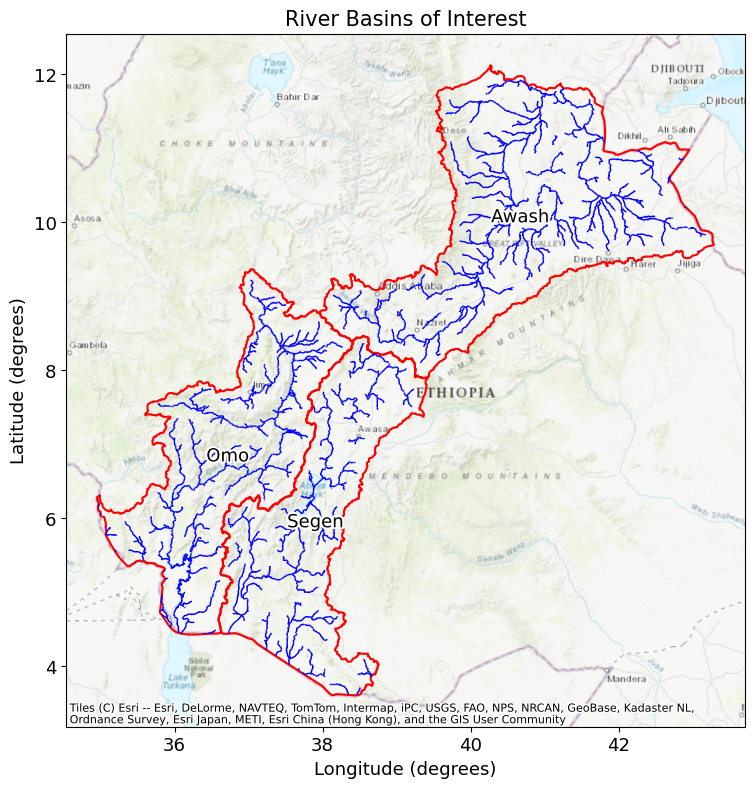

In [5]:
# Read file
aoi_path = '/Users/aprida/Documents/Consulting/Public_sector/WB_Ethiopia/basins/eth_basins.shp'
gdf_aoi = gpd.read_file(aoi_path)
gdf_aoi = gdf_aoi.to_crs(4326)
aoi_name = 'eth_wb'
aoi_nickname = 'eth_wb'
continent = 'af'

# Identify the HydroRivers for the upstream basin (viz purposes only)
sql = f"SELECT hyriv_id, ord_stra, geom FROM hydrorivers_v10_{continent}" # Read HydroRIVERS of the selected continent
gdf_rivers = gpd.GeoDataFrame.from_postgis(sql,
                                           con=create_engine('postgresql://' + dbuser + ':' + dbpass + '@' + dbhost + ':' + dbport + '/' + 'aprida'))
gdf_rivers_sel = gpd.clip(gdf_rivers, gdf_aoi).reset_index(drop=True) # Identify HydroRivers within the basin of interest

# Plot polygon of Ile de France
plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(figsize=(15,9))
gdf_aoi.boundary.plot(ax=ax, edgecolor='r')
gdf_rivers_sel[gdf_rivers_sel['ord_stra']>=3].plot(ax=ax, color='blue', linewidth=1)
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap, )
ax.set_title(label=f'River Basins of Interest', fontsize=15)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

for idx, row in gdf_aoi.iterrows():
    centroid = row['geometry'].centroid
    text = ax.annotate(text=row['BASIN_NAME'], xy=(centroid.x, centroid.y),
                horizontalalignment='center', verticalalignment='center')
    text.set_path_effects([
                    path_effects.Stroke(linewidth=3, foreground='white'),
                    path_effects.Normal()
                ])

# Upload AOI polygon to PostGIS
# tablename = f'{aoi_nickname}_pol'
# gdf_aoi.to_postgis(name=tablename, con=con, index=True, if_exists='replace',
#                        dtype={'geometry': Geometry(geometry_type='POLYGON', srid=4326)
#                              })

# # Upload river polylines to PostGIS
# tablename = f'{aoi_nickname}_hydrorivers'
# gdf_rivers_sel.to_postgis(name=tablename, con=con, index=True, if_exists='replace',
#                        dtype={'geometry': Geometry(geometry_type='MULTILINESTRING', srid=4326)
#                              })


# Hazard


At AXA Climate, we use Amazon Web Services S3 server to store the raster tiles of the Fathom Global Flood Maps. To have access to S3 from the local machine, it is necessary to login to AWS SSO beforehand (check Notion for more information on this topic). Once logged in, we can retrieve the folders of the flood scenarios we are interested in. Below, there are shown the different options available to define scenarios (RPs, time horizons, SSPs, etc.).

In [ ]:
# Specify your S3 bucket name and prefix (directory) where flood data is located
bucket_name = 'axa-climate-datastore-fathom'
prefix = 'Flood_RiskMap_Fathom/v3/'
include_pattern = r'Flood_RiskMap_Fathom/v3/.*v3\.0'
exclude_pattern = r'Flood_RiskMap_Fathom/v3/.*v3\.0\.0'

scenario_list = get_s3_folder_list(bucket_name, prefix, include_pattern, exclude_pattern) # List of all folders matching the include pattern but excluding the exclude pattern

## Identify flood scenarios

# Time horizons
search_string = ['2011'] #  Options: ['2011', '2030', '2050']
scenario_list = [element for element in scenario_list if any(search_strings in element for search_strings in search_string)]

# # Flood type
search_string = ['FLUVIAL', 'PLUVIAL'] # Options: ['FLUVIAL', 'PLUVIAL', 'COASTAL']
scenario_list = [element for element in scenario_list if any(search_strings in element for search_strings in search_string)]

# # Return period
search_string = ['1in5-', '1in10-', '1in20-', '1in50-', '1in100-', '1in200-', '1in500-', '1in1000-'] # Options: ['1in5-', '1in10-', '1in20-', '1in50-', '1in100-', '1in200-', '1in500-', '1in1000-']
scenario_list = [element for element in scenario_list if any(search_strings in element for search_strings in search_string)]

# # # Socioeconomic Pathway (SSP)
# search_string = ['SSP5'] # Options: ['SSP1', 'SSP2', 'SSP5']
# scenario_list = [element for element in scenario_list if any(search_strings in element for search_strings in search_string)]

# # Percentile
search_string = 'PERCENTILE50' # ['PERCENTILE17', 'PERCENTILE83']
scenario_list = [element for element in scenario_list if search_string in element]

# # # Defences
search_string = '-UNDEFENDED' # Options: ['-DEFENDED', '-UNDEFENDED']
scenario_pluvial_list = [element for element in scenario_list if 'PLUVIAL' in element]
scenario_list = [element for element in scenario_list if search_string not in element]
scenario_list = scenario_list + scenario_pluvial_list
scenario_list = set(scenario_list)
scenario_list = sorted(list(scenario_list))

print(f'\n{len(scenario_list)} scenarios have been selected.')
scenario_list

In [9]:
### Generate Fathom tiles
gdf_tiles_fathom = tiles_fathom_glob()

# Upload exposure polygon to PostGIS
tablename = 'fathom_tiles'
gdf_tiles_fathom.to_postgis(name=tablename, con=con, index=True, if_exists='replace',
                       dtype={'geometry': Geometry(geometry_type='POLYGON', srid=4326)
                             })

# Identify Fathom tiles intersected by exposure polygon
query = f"""
select tile_name
from fathom_tiles as t, {aoi_nickname}_pol as e
where st_intersects(t.geometry, e.geometry)
"""

tiles = list(pd.read_sql(query, con=con)['tile_name'])

# Remove duplicates
tiles = set(tiles)
tiles = list(tiles)

# Specify your S3 bucket name and prefix (directory) where flood data is located
bucket_name = 'axa-climate-datastore-fathom'
prefix = 'Flood_RiskMap_Fathom/v3/'
include_pattern = r'Flood_RiskMap_Fathom/v3/.*v3\.0'
exclude_pattern = r'Flood_RiskMap_Fathom/v3/.*v3\.0\.0'

scenario_list = get_s3_folder_list(bucket_name, prefix, include_pattern, exclude_pattern) # List of all folders matching the include pattern but excluding the exclude pattern

## Identify flood scenarios

# Time horizons
search_string = ['2011'] #  Options: ['2011', '2030', '2050']
scenario_list = [element for element in scenario_list if any(search_strings in element for search_strings in search_string)]

# # Flood type
search_string = ['FLUVIAL', 'PLUVIAL'] # Options: ['FLUVIAL', 'PLUVIAL', 'COASTAL']
scenario_list = [element for element in scenario_list if any(search_strings in element for search_strings in search_string)]

# # Return period
search_string = ['1in5-', '1in10-', '1in20-', '1in50-', '1in100-', '1in200-', '1in500-', '1in1000-'] # Options: ['1in5-', '1in10-', '1in20-', '1in50-', '1in100-', '1in200-', '1in500-', '1in1000-']
scenario_list = [element for element in scenario_list if any(search_strings in element for search_strings in search_string)]

# # # Socioeconomic Pathway (SSP)
# search_string = ['SSP5'] # Options: ['SSP1', 'SSP2', 'SSP5']
# scenario_list = [element for element in scenario_list if any(search_strings in element for search_strings in search_string)]

# # Percentile
search_string = 'PERCENTILE50' # ['PERCENTILE17', 'PERCENTILE83']
scenario_list = [element for element in scenario_list if search_string in element]

# # # Defences
search_string = '-UNDEFENDED' # Options: ['-DEFENDED', '-UNDEFENDED']
scenario_pluvial_list = [element for element in scenario_list if 'PLUVIAL' in element]
scenario_list = [element for element in scenario_list if search_string not in element]
scenario_list = scenario_list + scenario_pluvial_list
scenario_list = set(scenario_list)
scenario_list = sorted(list(scenario_list))

print(f'\n{len(scenario_list)} scenarios have been selected.')
scenario_list


16 scenarios have been selected.


['Flood_RiskMap_Fathom/v3/GLOBAL-1ARCSEC-NW_OFFSET-1in10-FLUVIAL-DEFENDED-DEPTH-2011-PERCENTILE50-v3.0',
 'Flood_RiskMap_Fathom/v3/GLOBAL-1ARCSEC-NW_OFFSET-1in10-PLUVIAL-DEFENDED-DEPTH-2011-PERCENTILE50-v3.0',
 'Flood_RiskMap_Fathom/v3/GLOBAL-1ARCSEC-NW_OFFSET-1in100-FLUVIAL-DEFENDED-DEPTH-2011-PERCENTILE50-v3.0',
 'Flood_RiskMap_Fathom/v3/GLOBAL-1ARCSEC-NW_OFFSET-1in100-PLUVIAL-DEFENDED-DEPTH-2011-PERCENTILE50-v3.0',
 'Flood_RiskMap_Fathom/v3/GLOBAL-1ARCSEC-NW_OFFSET-1in1000-FLUVIAL-DEFENDED-DEPTH-2011-PERCENTILE50-v3.0',
 'Flood_RiskMap_Fathom/v3/GLOBAL-1ARCSEC-NW_OFFSET-1in1000-PLUVIAL-DEFENDED-DEPTH-2011-PERCENTILE50-v3.0',
 'Flood_RiskMap_Fathom/v3/GLOBAL-1ARCSEC-NW_OFFSET-1in20-FLUVIAL-DEFENDED-DEPTH-2011-PERCENTILE50-v3.0',
 'Flood_RiskMap_Fathom/v3/GLOBAL-1ARCSEC-NW_OFFSET-1in20-PLUVIAL-DEFENDED-DEPTH-2011-PERCENTILE50-v3.0',
 'Flood_RiskMap_Fathom/v3/GLOBAL-1ARCSEC-NW_OFFSET-1in200-FLUVIAL-DEFENDED-DEPTH-2011-PERCENTILE50-v3.0',
 'Flood_RiskMap_Fathom/v3/GLOBAL-1ARCSEC-NW_OFFS

In [ ]:
## Download the rasters of preselected flood scenarios to local directory

# Create new directory to store files
dir = f'{root}/fathom_rasters_{aoi_nickname}'
os.makedirs(dir, exist_ok=True)

# Generate S3 filepaths
filepaths = [f's3://{bucket_name}/{x}/{y}.tif' for x in scenario_list for y in tiles]

# Set up variables to upload outputs to PostGIS DB
target_datasource = f'PG:"dbname={dbname} user={dbuser} password={dbpass} host={dbhost} port={dbport}"'
variable = 'depth'
df_fl = pd.DataFrame()
fl_threshold = np.arange(0, 101, 20) # Flood thresholds (in cm)

for scenario in scenario_list:

    dir_scenario = os.path.join(dir, scenario.split('/')[-1])
    os.makedirs(dir_scenario, exist_ok=True)
    files_scenario = [file for file in filepaths if scenario in file]

    # Download Fathom raster tiles per scenario from AWS S3
    for file in files_scenario:

        filename = f"{file.split('/')[-2]}_{file.split('/')[-1]}"
        query = f"""
        aws s3 cp "{file}" "{dir_scenario}/{filename}"
        """
        try:
            os.system(query)
        except:
            print('This file does not exist.')
            pass

    # Merge downloaded tiles
    cmd = f"gdal_merge.py -o {dir_scenario}.tif {dir_scenario}/*.tif"
    os.system(cmd)

    filename = f'{dir_scenario}.tif'
    raster = rxr.open_rasterio(filename)
    raster.values = np.where(raster.values < 0, 0, raster.values)
    raster.rio.to_raster(filename)

    OutTile = gdal.Warp(destNameOrDestDS = filename, # directory output
              srcDSOrSrcDSTab = filename, # directoy input
              cutlineDSName= aoi_path, # vector file
              cropToCutline = True,
                        dstNodata = 0) # Select True
    OutTile = None
    
    shutil.rmtree(dir_scenario) # Remove folder
    print(scenario)

In [ ]:
## Polygonise rasters of flood scenarios and upload to PostGIS database

# Read paths to flood hazard rasters
dir = f'{root}/fathom_rasters_{aoi_nickname}'
fl_hazard_rasters = glob.glob(os.path.join(dir, '*.tif'))

# Set PostGIS target data source and colname of the polygonized attribute
target_datasource = f'PG:"dbname={dbname} user={dbuser} password={dbpass} host={dbhost} port={dbport}"'
variable = 'depth'

# Upload flood hazard vector files to PostGIS database
for raster in fl_hazard_rasters:

    table_name = 'RP' + '_'.join(raster.split('/')[-1].split('.')[0].split('-')[3:-1]).split('in')[-1]
    raster_to_polygon(raster, target_datasource, table_name, variable) # Polygonize reclassified raster
    os.remove(raster)

# Exposure

The exposure layers used in this project are population and building databases.

Sources:
- **WorldPop Population**: https://hub.worldpop.org/geodata/summary?id=49686
- **WorldPop Buildings**: https://wopr.worldpop.org/?ETH/Buildings
- **Google Open Buildings**: https://sites.research.google/open-buildings/#download


## Property

### Using Google Open Buildings

In [ ]:
# Merge tables of buildings into one table
gdf_buildings = gpd.GeoDataFrame()

for index, row in gdf_aoi_tiles.drop_duplicates(subset='tile_url').reset_index(drop=True).iterrows():

    table_buildings_aoi = f'buildings_{row["tile_id"]}_aoi'
    query = f"""
    select *
    from {table_buildings_aoi}
    """
    gdf_buildings_tmp = gpd.read_postgis(query, con, geom_col='geometry')
    gdf_buildings = pd.concat([gdf_buildings, gdf_buildings_tmp], axis=0)

    print(table_buildings_aoi)

In [ ]:
# Convert geometries to MultiPolygons for consistency
gdf_buildings = gdf_buildings.reset_index(drop=True)
gdf_buildings['geometry'] = gdf_buildings['geometry'].apply(ensure_multipolygon)

# Upload table of buildings within AOI to PostGIS
tablename = 'buildings_aoi_google'
gdf_buildings.to_postgis(name=tablename, con=con, index=True, if_exists='replace',
                       dtype={'geometry': Geometry(geometry_type='MULPOLYGON', srid=4326)
                             })

### Using WorldPop Building counts

WorldPop provides the building counts globally in a 100x100-meter resolution raster file. In this chapter, the global Buildings WorldPop database is clipped to the AOI and uploaded to a PostGIS database.

Source: https://wopr.worldpop.org/?ETH/

In [ ]:
# Read building counts raster
filename = f'{root}/data/ETH_buildings_v1_1/ETH_buildings_v1_1_count.tif'
filename_output = f'{root}/data/{aoi_nickname}_buildings_v1_1_count.tif'

# Clip building counts raster to AOI
OutTile = gdal.Warp(destNameOrDestDS = filename_output, # directory output
          srcDSOrSrcDSTab = filename, # directoy input
          cutlineDSName= aoi_path, # vector file
          cropToCutline = True,
                    dstNodata = 0) # Select True
OutTile = None

# Polygonize raster of population counts for the AOI
with rio.open(filename_output) as src:
    
    image = src.read(1)
    mask = image != src.nodata
    results = (
        {'properties': {'buildings': round(v)}, 'geometry': s}
        for i, (s, v) in enumerate(
            shapes(image, mask=mask, transform=src.transform))
    )
    geoms = list(results)
    gdf_bld = gpd.GeoDataFrame.from_features(geoms, crs=4326)

# Upload polygonized raster to PostGIS database
target_datasource = f'PG:"dbname={dbname} user={dbuser} password={dbpass} host={dbhost} port={dbport}"'
tablename_pop = f'{aoi_nickname}_buildings_v1_1_count'
gdf_bld.to_postgis(name=tablename_pop, con=con, index=True, if_exists='replace',
                      dtype={'geometry': Geometry(geometry_type='POLYGON', srid=4326)
                             })

In [ ]:
# Plot WorldPop Building Exposure layer
tablename_bld = f'{aoi_nickname}_buildings_v1_1_count'
query = f"""
select *
from {tablename_bld}
"""
gdf_bld = gpd.read_postgis(query, con, geom_col='geometry')

tablename = 'eth_wb_pol'
query = f"""
select *
from {tablename}
"""
gdf_basins = gpd.read_postgis(query, con, geom_col='geometry')

plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(figsize=(16,9))

divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="5%", pad=0.8)
gdf_bld.plot(ax=ax, column='buildings', cmap='Reds', legend=True, cax=cax, legend_kwds={"orientation": "horizontal"}, vmin=0, vmax=1000)
gdf_basins.boundary.plot(ax=ax, edgecolor='lime')
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldImagery, attribution=False)
ax.set_title(label='WorldPop Buildings (100x100 meter)', fontsize=15)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

## Population

The population exposure is extracted from WorldPop (constrained UN adjusted 100x100m population counts in Ethiopia). In this chapter, the global Population WorldPop database is clipped to the AOI and uploaded to a PostGIS database.

Source: https://hub.worldpop.org/geodata/summary?id=49686

In [ ]:
# Download raster of population counts in Ethiopia to local
url = 'https://data.worldpop.org/GIS/Population/Global_2000_2020_Constrained/2020/maxar_v1/ETH/eth_ppp_2020_UNadj_constrained.tif'
filename = f'{root}/data/eth_ppp_2020_UNadj_constrained.tif'
response = requests.get(url)

with open(filename, 'wb') as f:
    f.write(response.content)

# Clip raster of population counts to basin polygon
raster = rxr.open_rasterio(filename)
raster.values = np.where(raster.values < 0, 0, raster.values)
raster.rio.to_raster(filename)

filename_output = f'{root}/data/{aoi_nickname}_ppp_2020_UNadj_constrained.tif'
OutTile = gdal.Warp(destNameOrDestDS = filename_output, # directory output
          srcDSOrSrcDSTab = filename, # directoy input
          cutlineDSName= aoi_path, # vector file
          cropToCutline = True,
                    dstNodata = 0) # Select True
OutTile = None

# Polygonize raster of population counts for the AOI
with rio.open(filename_output) as src:
    
    image = src.read(1)
    mask = image != src.nodata
    results = (
        {'properties': {'popcounts': round(v)}, 'geometry': s}
        for i, (s, v) in enumerate(
            shapes(image, mask=mask, transform=src.transform))
    )
    geoms = list(results)
    gdf_pop = gpd.GeoDataFrame.from_features(geoms, crs=4326)

# Upload polygonized raster to PostGIS database
target_datasource = f'PG:"dbname={dbname} user={dbuser} password={dbpass} host={dbhost} port={dbport}"'
tablename_pop = f'{aoi_nickname}_ppp_2020_unadj_constrained'
gdf_pop.to_postgis(name=tablename_pop, con=con, index=True, if_exists='replace',
                      dtype={'geometry': Geometry(geometry_type='POLYGON', srid=4326)
                             })

In [ ]:
# Plot WorldPop Building Exposure layer
tablename_pop = f'{aoi_nickname}_ppp_2020_unadj_constrained'
query = f"""
select *
from {tablename_pop}
"""
gdf_pop = gpd.read_postgis(query, con, geom_col='geometry')

plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(figsize=(16,9))

divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="5%", pad=0.8)
gdf_pop.plot(ax=ax, column='popcounts', cmap='Reds', legend=True, cax=cax, legend_kwds={"orientation": "horizontal"}, vmin=0, vmax=1000)
gdf_basins.boundary.plot(ax=ax, edgecolor='lime')
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldImagery, attribution=False)
ax.set_title(label='WorldPop Buildings (100x100 meter)', fontsize=15)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

In [12]:
# Create Population exposure layer, including overlay with admin boundaries and basins

tn_admin = 'eth_woredas'
tn_basins = 'eth_wb_pol'
tn_pop = 'eth_wb_ppp_2020_unadj_constrained'
tn_output = 'eth_wb_exposure'
query = f"""
drop table if exists {tn_output};
create table {tn_output} as
with tmp_bis as (
    with tmp as (
        select
            a.popcounts, st_area(a.geometry::geography) as area_original_sqm,
            r.regionname, r.zonename, r.woredaname,
            st_intersection(a.geometry, r.geometry) as geometry
        from
            eth_wb_ppp_2020_unadj_constrained as a,
	eth_woredas as r
        where
            st_intersects(a.geometry, r.geometry)
    )
    select
        st_area(tmp.geometry::geography) as area_level_woreda_sqm,
        st_area(tmp.geometry::geography) / tmp.area_original_sqm * tmp.popcounts as popcounts,
        tmp.regionname, tmp.zonename, tmp.woredaname,
        tmp.geometry

    from tmp
)
select
            b."BASIN_NAME", tmp_bis.regionname, tmp_bis.zonename, tmp_bis.woredaname,
            st_area(tmp_bis.geometry::geography) / tmp_bis.area_level_woreda_sqm * tmp_bis.popcounts as popcounts,
            st_intersection(tmp_bis.geometry, b.geometry) as geometry
from
    tmp_bis,
    eth_wb_pol as b
where
    st_intersects(tmp_bis.geometry, b.geometry);
"""

# Execute the queries
with con.connect() as connection:
    connection.execute(text(query))
    connection.commit()

In [20]:
tn_exposure = 'eth_wb_exposure_bld'
query = f"""
select *
from {tn_exposure}
"""
gdf_exposure = gpd.read_postgis(query, con, geom_col='geometry')
gdf_exposure

BASIN_NAME regionname zonename woredaname  buildings  \
0            Awash       Afar   Zone 4       Awra   1.000000   
1            Awash       Afar   Zone 4       Awra   2.000000   
2            Awash       Afar   Zone 4       Awra   3.000000   
3            Awash       Afar   Zone 4       Awra   2.000000   
4            Awash       Afar   Zone 4       Awra   1.000000   
...            ...        ...      ...        ...        ...   
2556326      Segen     Oromia   Borena      Dillo   1.000000   
2556327      Segen     Oromia   Borena       Dire   4.000000   
2556328      Segen     Oromia   Borena       Miyo   0.940849   
2556329      Segen     Oromia   Borena       Miyo   1.000000   
2556330      Segen     Oromia   Borena       Miyo   1.000000   

                                                  geometry  
0        POLYGON ((40.26375 12.06458, 40.26208 12.06458...  
1        POLYGON ((40.24542 12.06375, 40.24458 12.06375...  
2        POLYGON ((40.24542 12.06292, 40.24458 12.06292...  
3        POLYGON ((40.24625 12.06292, 40.24542 12.06292...  
4        POLYGON ((40.26708 12.06125, 40.26625 12.06125...  
...                                                    ...  
2556326  POLYGON ((38.31542 3.64292, 38.31375 3.64292, ...  
2556327  POLYGON ((38.45458 3.64292, 38.45375 3.64292, ...  
2556328  POLYGON ((38.51208 3.64375, 38.51285 3.64375, ...  
2556329  POLYGON ((38.51042 3.64042, 38.50958 3.64042, ...  
2556330  POLYGON ((38.51292 3.64042, 38.51208 3.64042, ...  

[2556331 rows x 6 columns]

In [21]:
fn = '/Users/aprida/Desktop/test.csv'
gdf_exposure_pivot = gdf_exposure.pivot_table(values='buildings', index=['BASIN_NAME', 'regionname', 'zonename', 'woredaname'], aggfunc='sum')
gdf_exposure_pivot.to_csv(fn)

# Flood risk assessment

In this chapter, the flood risk is computed for population and buildings across the AOI. First, the hazard, exposure and vulnerability layer are combined to compute the overall annual average affected buildings and population across the AOI for fluvial and pluvial flooding separately, assuming that population and buildings are affected if flood depth exceeds a certain threshold (e.g. 50 cm, one-step vulnerability curve). Subsequently, the risk metrics are disaggregated per Woreda (admin level 3), which will inform the spatial distribution of pluvial and fluvial flood risk across the AOI.

## Property

### Computation

#### Open Google Buildings

#### WorldPop Buildings

**Note**: Performing the intersection for buildings with RP5 flood hazard map, using PostGIS operations it takes 01:05 minutes. Using geopandas.overlay() function, the same operation takes 03:03 minutes (and crashes).

In [ ]:
# List tables with flood depth vector layers
query = """
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public';
"""

table_names = pd.read_sql(query, con)['table_name']
table_names = [element for element in table_names if element.startswith('rp')]
tablename_bld = 'eth_wb_buildings_v1_1_count'
threshold = 50 # Flood depth threshold in cm

# Extract maximum flood depth per polygon
gdf_max_fl = gpd.GeoDataFrame()
t_start = datetime.now()

for table_name in table_names:
    
    query = f"""
    with tmp as (
            select
                st_area(f.wkb_geometry::geography) AS area_original_sqm,
                f.depth,
                f.wkb_geometry as geometry
            from
                {table_name} as f
            where
                f.depth >= {threshold})
    select
        e.index,
        tmp.area_original_sqm,
        tmp.depth,
        e.buildings,
        st_intersection(tmp.geometry, e.geometry) as geometry
    from
        tmp,
        {tablename_bld} as e
    where
        st_intersects(tmp.geometry, e.geometry);
        """

    # Execute the SQL command to create the PostGIS extension
    gdf_tmp = gpd.read_postgis(text(query), con, geom_col='geometry')
    gdf_tmp['scenario'] = table_name
    gdf_max_fl = pd.concat([gdf_max_fl, gdf_tmp]).reset_index(drop=True)

    print(table_name)
    print(datetime.now() - t_start)

# Add attributes and save to PostGIS
gdf_max_fl_summary = gdf_max_fl.copy()
gdf_max_fl_summary['rp'] = gdf_max_fl_summary['scenario'].apply(lambda x: x.split('_')[0].split('rp')[1])
gdf_max_fl_summary['floodtype'] = gdf_max_fl_summary['scenario'].apply(lambda x: x.split('_')[1])
gdf_max_fl_summary['defences'] = gdf_max_fl_summary['scenario'].apply(lambda x: x.split('_')[2])
gdf_max_fl_summary['geometry'] = gdf_max_fl_summary['geometry'].apply(ensure_multipolygon)

print(datetime.now() - t_start)

# Upload output to PostGIS database
tablename = f'output_bld_risk_{aoi_nickname}'
gdf_max_fl_summary.to_postgis(name=tablename, con=con, index=True, if_exists='replace',
                      dtype={'geometry': Geometry(geometry_type='MULPOLYGON', srid=4326)
                             })

# Add the new column for the area of the intersection geometries
tablename = f'output_bld_risk_{aoi_nickname}'
colname_new = 'buildings_flooded'
colname_original = 'buildings'

add_column_query = f"""si
ALTER TABLE {tablename}
ADD COLUMN area_intersection_sqm DOUBLE PRECISION,
ADD COLUMN {colname_new} INTEGER;
"""

# Update the new column with the area of the intersection geometries
update_query = f"""
UPDATE {tablename}
SET area_intersection_sqm = ST_Area(geometry::geography);
UPDATE {tablename}
SET {colname_new} = round(area_intersection_sqm / area_original_sqm * {colname_original});
"""

# Execute the queries
with con.connect() as connection:
    connection.execute(text(add_column_query))
    connection.execute(text(update_query))
    connection.commit()

In [191]:
t_start = datetime.now()

# Spatial disaggregation of population affected per Woreda

tablename_risk = f'output_bld_risk_{aoi_nickname}'
tablename_admin = 'eth_woredas'
tablename_final = f'output_bld_risk_{aoi_nickname}_admin3'

query = f"""
drop table if exists {tablename_final};
create table {tablename_final} as
select
    r.index, r.area_original_sqm, r.depth, r.buildings, r.rp, r.floodtype, r.defences,
    a.regionname, a.zonename, a.woredaname,
    st_intersection(r.geometry, a.geometry) as geometry
from
    {tablename_risk} as r,
    {tablename_admin} as a
where
    st_intersects(r.geometry, a.geometry);
"""

with con.connect() as connection:
    connection.execute(text(query))
    connection.commit()

print(datetime.now() - t_start)

# Add the new column for the area of the intersection geometries
colname_new = 'buildings_flooded'
colname_original = 'buildings'

add_column_query = f"""
ALTER TABLE {tablename_final}
ADD COLUMN area_intersection_sqm DOUBLE PRECISION,
ADD COLUMN {colname_new} INTEGER;
"""

# Update the new column with the area of the intersection geometries
update_query = f"""
UPDATE {tablename_final}
SET area_intersection_sqm = ST_Area(geometry::geography);
UPDATE {tablename_final}
SET {colname_new} = round(area_intersection_sqm / area_original_sqm * {colname_original});
"""

# Execute the queries
with con.connect() as connection:
    connection.execute(text(add_column_query))
    connection.execute(text(update_query))
    connection.commit()

print(datetime.now() - t_start)

0:01:46.839642
0:04:05.898271


In [107]:
# Read affected population per scenario table
tablename_final = f'output_bld_risk_{aoi_nickname}_admin3'
query = f"""
select r.index, r.depth, r.rp, r.floodtype, r.regionname, r.zonename, r.woredaname, r.buildings_flooded
from {tablename_final} as r
"""

df_risk_admin = pd.read_sql(query, con)
df = df_risk_admin.pivot_table(values='buildings_flooded', index=['regionname', 'zonename', 'woredaname', 'floodtype', 'rp'], aggfunc='sum').reset_index()
df['rp'] = df['rp'].astype(int)
df = df.sort_values(by='rp').reset_index(drop=True)
df['prob'] = 1 / df['rp']

# Compute Annual Average affected population per Woreda
def custom_aggfunc(df_subset):
    return abs(np.trapz(df_subset['buildings_flooded'], df_subset['prob']))

pivot_table = pd.pivot_table(df, 
                             values='buildings_flooded', 
                             index=['regionname', 'zonename', 'woredaname'], 
                             columns='floodtype', 
                             aggfunc=lambda x: custom_aggfunc(df.loc[x.index]))

In [108]:
# Merge Annual Average affected population per Woreda to polygons of the Woredas

tablename = 'eth_woredas'

query = f"""
WITH dissolved_pol AS (
    SELECT
        ST_Union(geometry) AS geometry
    FROM
        eth_wb_pol
)
SELECT
    r.regionname,
    r.zonename,
    r.woredaname,
    ST_Intersection(r.geometry, dp.geometry) AS geometry
FROM
    eth_woredas AS r,
    dissolved_pol AS dp
WHERE
    ST_Intersects(r.geometry, dp.geometry);

"""

gdf_woredas = gpd.read_postgis(query, con, geom_col='geometry')
df_merge = pd.merge(pivot_table, gdf_woredas, how='inner', on=['zonename', 'woredaname'])
gdf_merge = gpd.GeoDataFrame(df_merge, geometry='geometry', crs=4326).reset_index(drop=True)
gdf_merge['geometry'] = gdf_merge['geometry'].apply(ensure_multipolygon)

tablename_admin = 'eth_woredas'
tablename_bld = f'{aoi_nickname}_buildings_v1_1_count'
query = f"""
with tmp as (
select
	a.buildings, st_area(a.geometry::geography) as area_original_sqm,
    r.regionname, r.zonename, r.woredaname,
	st_intersection(r.geometry, a.geometry) as geometry
from
    {tablename_bld} as a,
	{tablename_admin} as r
where
    st_intersects(r.geometry, a.geometry)
	)
select
	st_area(tmp.geometry::geography) / tmp.area_original_sqm * tmp.buildings as buildings_admin,
	tmp.regionname, tmp.zonename, tmp.woredaname,
	tmp.geometry
	
from tmp;
"""

gdf = gpd.read_postgis(query, con, geom_col='geometry')
gdf_bldcovered = gdf.pivot_table(values='buildings_admin', index=['regionname', 'zonename', 'woredaname'], aggfunc='sum')
gdf_merge = pd.merge(gdf_merge, gdf_bldcovered, on=['regionname', 'zonename', 'woredaname'])
gdf_merge['aaab_pct_fl'] = gdf_merge['fluvial'] / gdf_merge['buildings_admin']
gdf_merge['aaab_pct_pl'] = gdf_merge['pluvial'] / gdf_merge['buildings_admin']

# Upload output to PostGIS database
tablename = f'aaa_bld_{aoi_nickname}_admin3'
gdf_merge.to_postgis(name=tablename, con=con, index=True, if_exists='replace',
                      dtype={'geometry': Geometry(geometry_type='MULPOLYGON', srid=4326)
                             })

### Visualisation


Annual Average Affected Buildings by Floods, for Fluvial and Pluvial Flooding:

|    |   fluvial |   pluvial |
|---:|----------:|----------:|
|  0 |   21091.9 |   57396.2 |




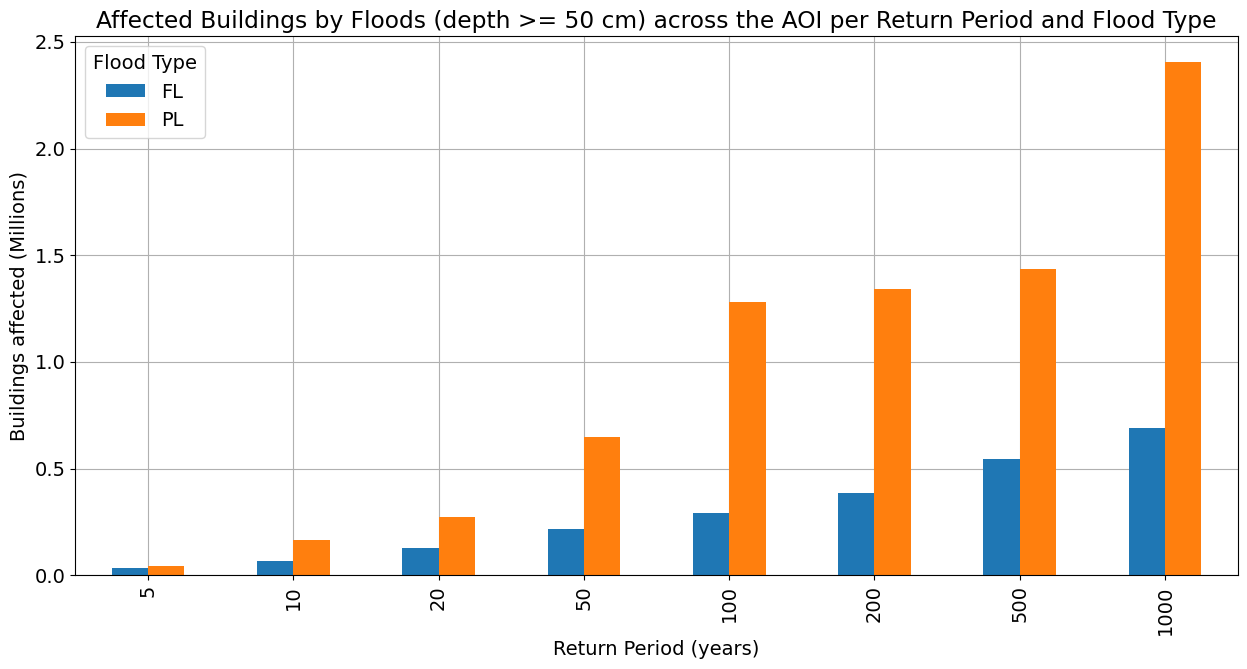

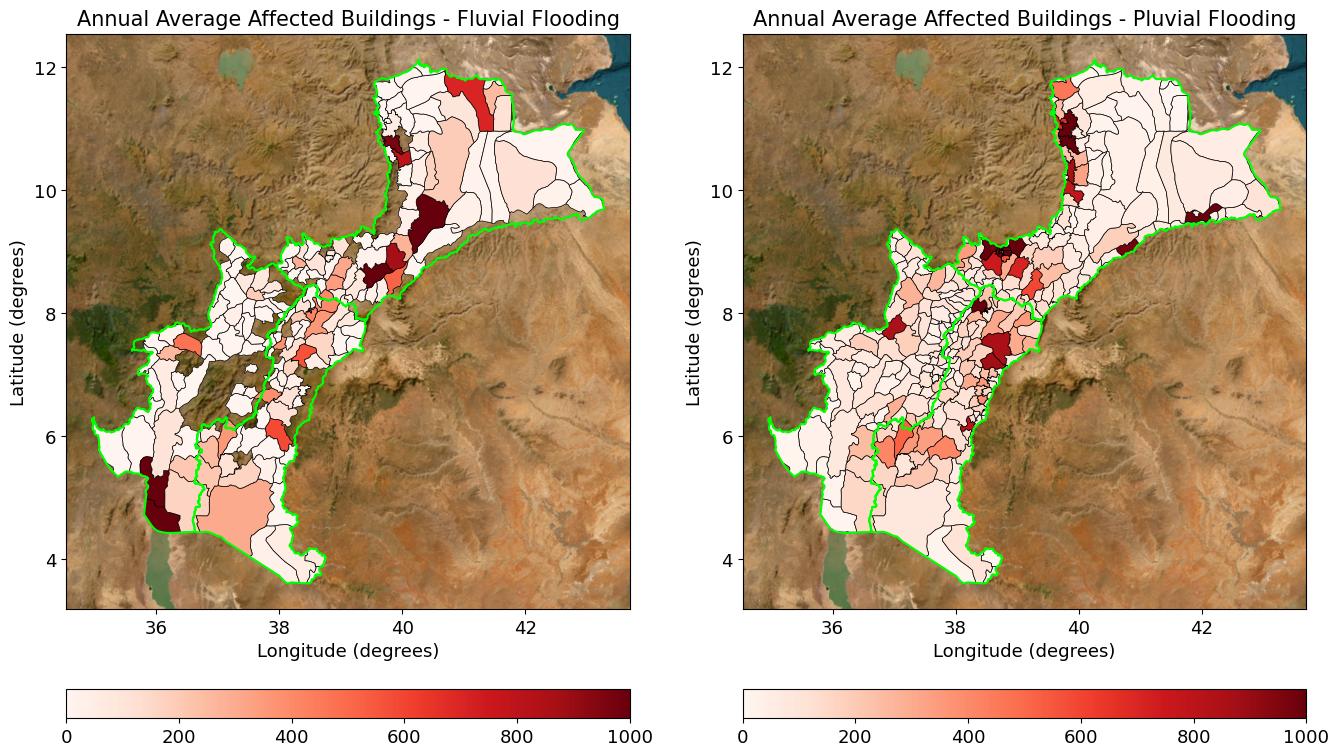

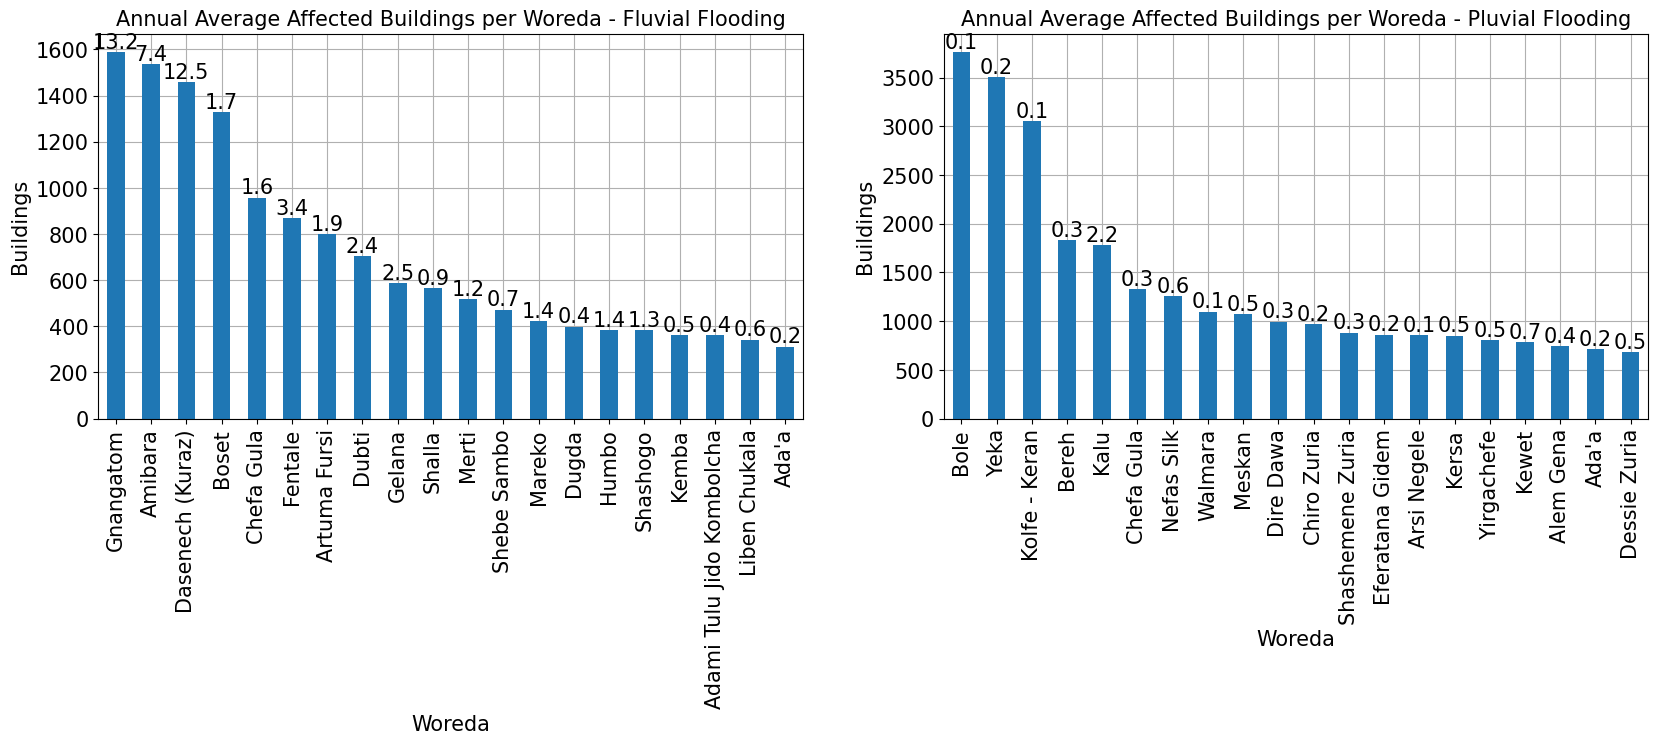

In [245]:
## Affected Population per event for whole AOI

df = df_risk_admin.sort_values(by='rp').reset_index(drop=True)
df['rp'] = df['rp'].astype(int)
df_pivot = df.pivot_table(index='rp', columns=['floodtype'], values='buildings_flooded', aggfunc='sum')
 
# Plot Population affected per scenario
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(figsize=(15,7))

(df_pivot / 1e6).plot(ax=ax, kind='bar', zorder=2)
ax.set_xlabel('Return Period (years)')
ax.set_ylabel('Buildings affected (Millions)')
ax.legend(title='Flood Type', labels=['FL', 'PL'])
ax.set_title('Affected Buildings by Floods (depth >= 50 cm) across the AOI per Return Period and Flood Type')
ax.grid()

plt.savefig('/Users/aprida/Documents/Consulting/Public_sector/WB_Ethiopia/presentations/figures/bld_affected_per_event.jpeg', format='jpeg', dpi=300, bbox_inches='tight')

## Spatial distribution of the Annual Average Affected Buildings for Fluvial and Pluvial Flooding per Woreda

tablename = 'eth_wb_pol'
query = f"""
select *
from {tablename}
"""
gdf_basins = gpd.read_postgis(query, con, geom_col='geometry')

plt.rcParams['font.size'] = 13

fig, (ax1, ax2) = plt.subplots(figsize=(16,9), ncols=2, nrows=1)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="5%", pad=0.8)
gdf_merge.plot(ax=ax1, column='fluvial', cmap='Reds', legend=True, cax=cax, legend_kwds={"orientation": "horizontal"}, vmin=0, vmax=1000, edgecolor='black', linewidth=0.5)
gdf_basins.boundary.plot(ax=ax1, edgecolor='lime')
cx.add_basemap(ax=ax1, crs=4326, source=cx.providers.Esri.WorldImagery, attribution=False)
ax1.set_title(label='Annual Average Affected Buildings - Fluvial Flooding', fontsize=15)
ax1.set_xlabel('Longitude (degrees)')
ax1.set_ylabel('Latitude (degrees)')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("bottom", size="5%", pad=0.8)
gdf_merge.plot(ax=ax2, column='pluvial', cmap='Reds', legend=True, cax=cax, legend_kwds={"orientation": "horizontal"}, vmin=0, vmax=1000, edgecolor='black', linewidth=0.5)
gdf_basins.boundary.plot(ax=ax2, edgecolor='lime')
cx.add_basemap(ax=ax2, crs=4326, source=cx.providers.Esri.WorldImagery, attribution=False)
ax2.set_title(label='Annual Average Affected Buildings - Pluvial Flooding', fontsize=15)
ax2.set_xlabel('Longitude (degrees)')
ax2.set_ylabel('Latitude (degrees)')

print(f"""
Annual Average Affected Buildings by Floods, for Fluvial and Pluvial Flooding:\n
{pd.DataFrame(gdf_merge[['fluvial', 'pluvial']].sum()).T.to_markdown()}\n
""")
    
plt.savefig('/Users/aprida/Documents/Consulting/Public_sector/WB_Ethiopia/presentations/figures/aaab_eth_wb.jpeg', format='jpeg', dpi=300)

## Annual Average Affected Population for most affected Woredas

gdf_sel_fluvial = gdf_merge.sort_values(by='fluvial', ascending=False).reset_index(drop=True)[:20]
gdf_sel_fluvial.set_index('woredaname', inplace=True)
gdf_sel_pluvial = gdf_merge.sort_values(by='pluvial', ascending=False).reset_index(drop=True)[:20]
gdf_sel_pluvial.set_index('woredaname', inplace=True)

plt.rcParams['font.size'] = 15
fig, (ax1, ax2) = plt.subplots(figsize=(20,5), ncols=2, nrows=1)
bars1 = gdf_sel_fluvial[['fluvial']].plot(ax=ax1, kind='bar', zorder=2, legend=False)
ax1.set_title(label='Annual Average Affected Buildings per Woreda - Fluvial Flooding', fontsize=15)
ax1.set_xlabel('Woreda')
ax1.set_ylabel('Buildings')
ax1.grid()

# Annotate bars for fluvial flooding
for bar, annotation in zip(bars1.patches, round(gdf_sel_fluvial['aaab_pct_fl']*100, 1)):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,  # X position of the text
        height,                             # Y position of the text (top of the bar)
        f'{annotation}',                    # Text to display
        ha='center',                        # Horizontal alignment
        va='bottom'                         # Vertical alignment
    )

bars2 = gdf_sel_pluvial[['pluvial']].plot(ax=ax2, kind='bar', zorder=2, legend=False)
ax2.set_title(label='Annual Average Affected Buildings per Woreda - Pluvial Flooding', fontsize=15)
ax2.set_xlabel('Woreda')
ax2.set_ylabel('Buildings')
ax2.grid()

# Annotate bars for fluvial flooding
for bar, annotation in zip(bars2.patches, round(gdf_sel_fluvial['aaab_pct_pl']*100, 1)):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2,  # X position of the text
        height,                             # Y position of the text (top of the bar)
        f'{annotation}',                    # Text to display
        ha='center',                        # Horizontal alignment
        va='bottom'                         # Vertical alignment
    )


plt.savefig('/Users/aprida/Documents/Consulting/Public_sector/WB_Ethiopia/presentations/figures/aaab_eth_wb_main_affected_woredas.jpeg', format='jpeg', dpi=300, bbox_inches='tight')

In [109]:
# Overlay with Basin polygons

tablename_risk_basin = 'aaa_bld_eth_wb_admin3_basin'
tablename_risk = 'aaa_bld_eth_wb_admin3'
tablename_basins = 'eth_wb_pol'
query = f"""
drop table if exists {tablename_risk_basin};
create table {tablename_risk_basin} as
	with tmp as (
	select
		st_area(r.geometry::geography) as area_original_sqm, r.pluvial, r.fluvial, r.regionname, r.zonename, r.woredaname,
		b."BASIN_NAME" as basin_name,
		st_intersection(r.geometry, b.geometry) as geometry
	from
		{tablename_risk} as r,
		{tablename_basins} as b
	where
		st_intersects(r.geometry, b.geometry)
	)
	select
		tmp.area_original_sqm, tmp.pluvial, tmp.fluvial, tmp.regionname, tmp.zonename, tmp.woredaname, tmp.basin_name,
		st_area(tmp.geometry::geography) as area_intersection_basin_sqm,
		st_area(tmp.geometry::geography) / tmp.area_original_sqm * tmp.pluvial as buildings_flooded_pluvial,
		st_area(tmp.geometry::geography) / tmp.area_original_sqm * tmp.fluvial as buildings_flooded_fluvial,
		tmp.geometry
	from tmp;
"""

with con.connect() as connection:
    connection.execute(text(query))
    connection.commit()

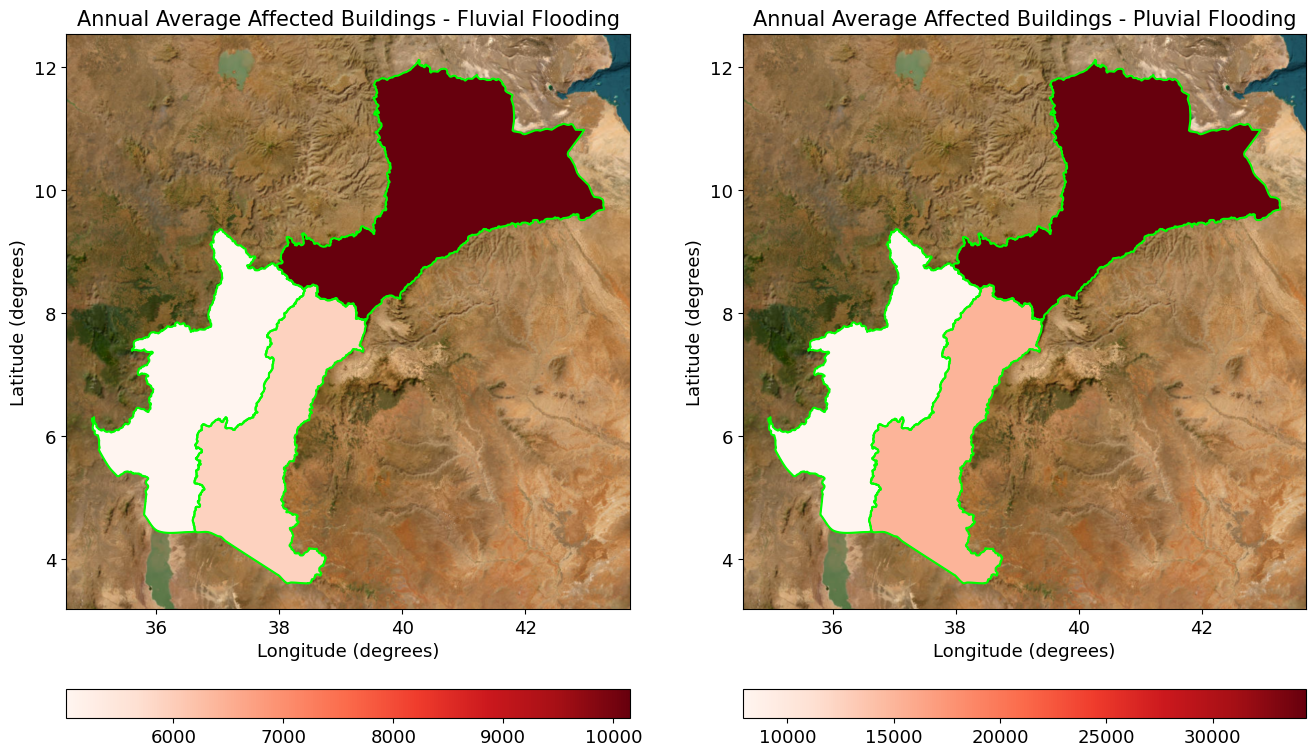

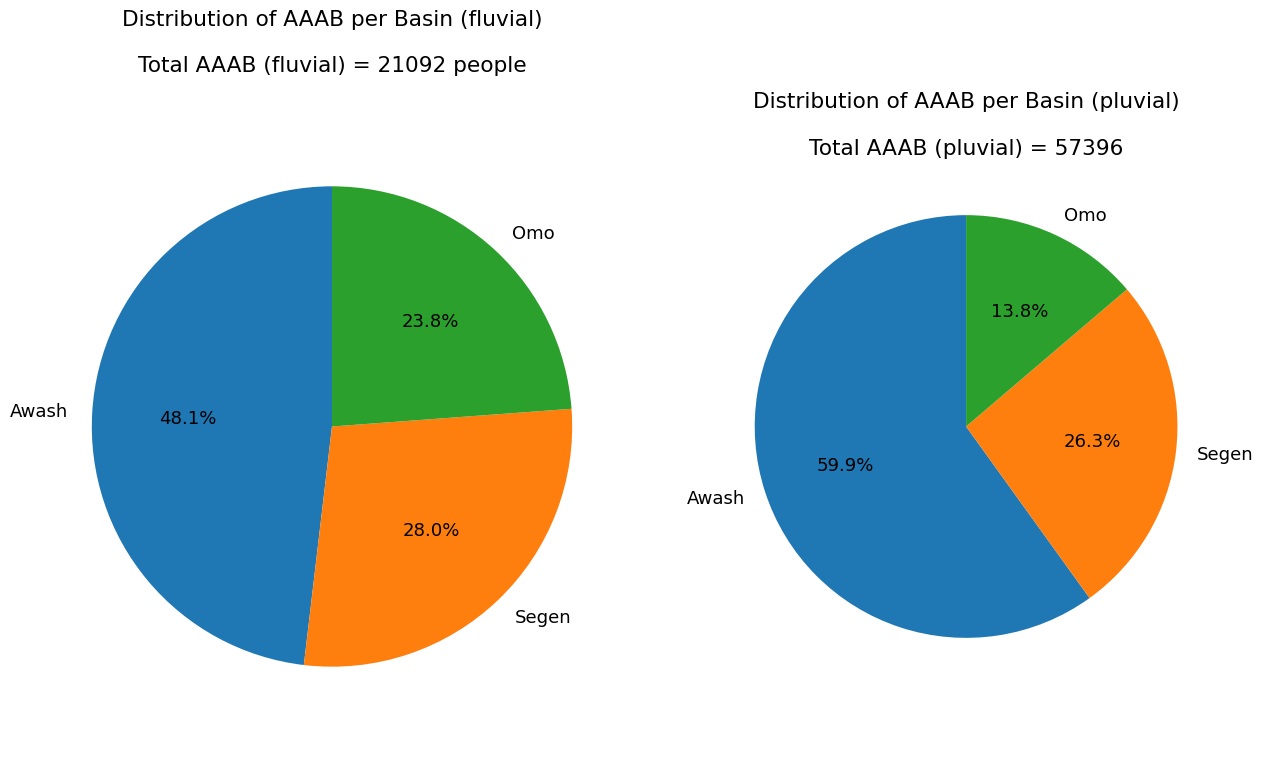

In [14]:
tablename = 'output_bld_risk_eth_wb_admin_basin'
query = f"""
select *
from {tablename}
"""

gdf_risk_basins = gpd.read_postgis(query, con, geom_col='geometry')
gdf_risk_basins = gdf_risk_basins.pivot_table(values=['buildings_flooded_pluvial', 'buildings_flooded_fluvial'], index='basin_name', aggfunc='sum')
gdf_risk_basins


tablename = 'eth_wb_pol'
query = f"""
select *
from {tablename}
"""
gdf_basins = gpd.read_postgis(query, con, geom_col='geometry')
gdf_basins.rename(columns={'BASIN_NAME': 'basin_name'}, inplace=True)
gdf_risk_basins = pd.merge(gdf_basins, gdf_risk_basins, on='basin_name')


# Plot annual average population affected, as agregated per basin

plt.rcParams['font.size'] = 13

fig, (ax1, ax2) = plt.subplots(figsize=(16,9), ncols=2, nrows=1)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="5%", pad=0.8)
gdf_risk_basins.plot(ax=ax1, column='buildings_flooded_fluvial', cmap='Reds', legend=True, cax=cax, legend_kwds={"orientation": "horizontal"}, vmin=gdf_risk_basins['buildings_flooded_fluvial'].min(), vmax=gdf_risk_basins['buildings_flooded_fluvial'].max(), edgecolor='black', linewidth=0.5)
gdf_basins.boundary.plot(ax=ax1, edgecolor='lime')
cx.add_basemap(ax=ax1, crs=4326, source=cx.providers.Esri.WorldImagery, attribution=False)
ax1.set_title(label='Annual Average Affected Buildings - Fluvial Flooding', fontsize=15)
ax1.set_xlabel('Longitude (degrees)')
ax1.set_ylabel('Latitude (degrees)')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("bottom", size="5%", pad=0.8)
gdf_risk_basins.plot(ax=ax2, column='buildings_flooded_pluvial', cmap='Reds', legend=True, cax=cax, legend_kwds={"orientation": "horizontal"}, vmin=gdf_risk_basins['buildings_flooded_pluvial'].min(), vmax=gdf_risk_basins['buildings_flooded_pluvial'].max(), edgecolor='black', linewidth=0.5)
gdf_basins.boundary.plot(ax=ax2, edgecolor='lime')
cx.add_basemap(ax=ax2, crs=4326, source=cx.providers.Esri.WorldImagery, attribution=False)
ax2.set_title(label='Annual Average Affected Buildings - Pluvial Flooding', fontsize=15)
ax2.set_xlabel('Longitude (degrees)')
ax2.set_ylabel('Latitude (degrees)')

plt.savefig('/Users/aprida/Documents/Consulting/Public_sector/WB_Ethiopia/presentations/figures/aaab_eth_wb_basins.jpeg', format='jpeg', dpi=300, bbox_inches='tight')

# Pie chart to show distribution of AAAP per basin
total_aaab_fl = round(gdf_risk_basins['buildings_flooded_fluvial'].sum())
total_aaab_pl = round(gdf_risk_basins['buildings_flooded_pluvial'].sum())

# Creating the pie chart
fig, (ax1, ax2) = plt.subplots(figsize=(15,9), ncols=2, nrows=1)
ax1.pie(gdf_risk_basins['buildings_flooded_fluvial'], labels=gdf_risk_basins['basin_name'], autopct='%1.1f%%', startangle=90)
ax1.set_title(f'Distribution of AAAB per Basin (fluvial)\n\nTotal AAAB (fluvial) = {total_aaab_fl} people')
ax2.pie(gdf_risk_basins['buildings_flooded_pluvial'], labels=gdf_risk_basins['basin_name'], autopct='%1.1f%%', startangle=90)
ax2.set_title(f'Distribution of AAAB per Basin (pluvial)\n\nTotal AAAB (pluvial) = {total_aaab_pl}')


# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')

plt.savefig('/Users/aprida/Documents/Consulting/Public_sector/WB_Ethiopia/presentations/figures/aaab_eth_wb_basins_piechart.jpeg', format='jpeg', dpi=300, bbox_inches='tight')

## Population

### Computation

In [ ]:
# List tables with flood depth vector layers
query = """
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public';
"""

table_names = pd.read_sql(query, con)['table_name']
table_names = [element for element in table_names if element.startswith('rp')]
tablename_pop = 'eth_wb_ppp_2020_unadj_constrained'
threshold = 50 # Flood depth threshold in cm

# Overlay
gdf_max_fl = gpd.GeoDataFrame()
t_start = datetime.now()

for table_name in table_names:

    query = f"""
    with tmp as (
            select
                st_area(f.wkb_geometry::geography) AS area_original_sqm, -- Compute original area of the polygons of population
                f.depth,
                f.wkb_geometry as geometry
            from
                {table_name} as f
            where
                f.depth >= {threshold})
    select
        e.index,
        tmp.area_original_sqm,
        tmp.depth,
        e.popcounts,
        st_intersection(tmp.geometry, e.geometry) as geometry
    from
        tmp,
        {tablename_pop} as e
    where
        st_intersects(tmp.geometry, e.geometry);
        """

    # Execute the SQL command to create the PostGIS extension
    gdf_tmp = gpd.read_postgis(text(query), con, geom_col='geometry')
    gdf_tmp['scenario'] = table_name
    gdf_max_fl = pd.concat([gdf_max_fl, gdf_tmp]).reset_index(drop=True)

    print(table_name)
    print(datetime.now() - t_start)

# Create pivot table with results summary
gdf_max_fl_summary = gdf_max_fl.copy()
gdf_max_fl_summary['rp'] = gdf_max_fl_summary['scenario'].apply(lambda x: x.split('_')[0].split('rp')[1])
gdf_max_fl_summary['floodtype'] = gdf_max_fl_summary['scenario'].apply(lambda x: x.split('_')[1])
gdf_max_fl_summary['defences'] = gdf_max_fl_summary['scenario'].apply(lambda x: x.split('_')[2])
gdf_max_fl_summary['geometry'] = gdf_max_fl_summary['geometry'].apply(ensure_multipolygon)

print(datetime.now() - t_start)

# Upload output to PostGIS database
tablename = f'output_pop_risk_{aoi_nickname}'
gdf_max_fl_summary.to_postgis(name=tablename, con=con, index=True, if_exists='replace',
                      dtype={'geometry': Geometry(geometry_type='MULPOLYGON', srid=4326)
                             })

# Add the new column for the area of the intersection geometries
tablename = f'output_pop_risk_{aoi_nickname}'
colname_new = 'popcounts_flooded'
colname_original = 'popcounts'

add_column_query = f"""
ALTER TABLE {tablename}
ADD COLUMN area_intersection_sqm DOUBLE PRECISION,
ADD COLUMN {colname_new} INTEGER;
"""

# Update the new column with the area of the intersection geometries
update_query = f"""
UPDATE {tablename}
SET area_intersection_sqm = ST_Area(geometry::geography); -- Compute the intersected area resulting from the overlay between exposure and hazard layers
UPDATE {tablename}
SET {colname_new} = round(area_intersection_sqm / area_original_sqm * {colname_original}); -- Compute proportional population to intersected area
"""

# Execute the queries
with con.connect() as connection:
    connection.execute(text(add_column_query))
    connection.execute(text(update_query))
    connection.commit()

In [49]:
t_start = datetime.now()

# Spatial disaggregation of population affected per Woreda

tablename_risk = f'output_pop_risk_{aoi_nickname}'
tablename_admin = 'eth_woredas'
tablename_final = f'output_pop_risk_{aoi_nickname}_admin3'

query = f"""
drop table if exists {tablename_final};
create table {tablename_final} as
select
    r.index, r.area_original_sqm, r.depth, r.popcounts, r.rp, r.floodtype, r.defences,
    a.regionname, a.zonename, a.woredaname,
    st_intersection(r.geometry, a.geometry) as geometry
from
    {tablename_risk} as r,
    {tablename_admin} as a
where
    st_intersects(r.geometry, a.geometry);
"""

with con.connect() as connection:
    connection.execute(text(query))
    connection.commit()

print(datetime.now() - t_start)

# Add the new column for the area of the intersection geometries
colname_new = 'popcounts_flooded'
colname_original = 'popcounts'

add_column_query = f"""
ALTER TABLE {tablename_final}
ADD COLUMN area_intersection_sqm DOUBLE PRECISION,
ADD COLUMN {colname_new} INTEGER;
"""

# Update the new column with the area of the intersection geometries
update_query = f"""
UPDATE {tablename_final}
SET area_intersection_sqm = ST_Area(geometry::geography);
UPDATE {tablename_final}
SET {colname_new} = round(area_intersection_sqm / area_original_sqm * {colname_original});
"""

# Execute the queries
with con.connect() as connection:
    connection.execute(text(add_column_query))
    connection.execute(text(update_query))
    connection.commit()

print(datetime.now() - t_start)

0:01:59.414761
0:04:28.546466


In [110]:
# Read affected population per scenario table
tablename_final = f'output_pop_risk_{aoi_nickname}_admin3'
query = f"""
select r.index, r.depth, r.rp, r.floodtype, r.regionname, r.zonename, r.woredaname, r.popcounts_flooded
from {tablename_final} as r
"""

df_risk_admin = pd.read_sql(query, con)
df = df_risk_admin.pivot_table(values='popcounts_flooded', index=['regionname', 'zonename', 'woredaname', 'floodtype', 'rp'], aggfunc='sum').reset_index()
df['rp'] = df['rp'].astype(int)
df = df.sort_values(by='rp').reset_index(drop=True)
df['prob'] = 1 / df['rp']

# Compute Annual Average affected population per Woreda
def custom_aggfunc(df_subset):
    return abs(np.trapz(df_subset['popcounts_flooded'], df_subset['prob']))

pivot_table = pd.pivot_table(df, 
                             values='popcounts_flooded', 
                             index=['regionname', 'zonename', 'woredaname'], 
                             columns='floodtype', 
                             aggfunc=lambda x: custom_aggfunc(df.loc[x.index]))

In [111]:
# Merge Annual Average affected population per Woreda to polygons of the Woredas

tablename = 'eth_woredas'

query = f"""
WITH dissolved_pol AS (
    SELECT
        ST_Union(geometry) AS geometry
    FROM
        eth_wb_pol
)
SELECT
    r.regionname,
    r.zonename,
    r.woredaname,
    ST_Intersection(r.geometry, dp.geometry) AS geometry
FROM
    eth_woredas AS r,
    dissolved_pol AS dp
WHERE
    ST_Intersects(r.geometry, dp.geometry);

"""

gdf_woredas = gpd.read_postgis(query, con, geom_col='geometry')
df_merge = pd.merge(pivot_table, gdf_woredas, how='inner', on=['regionname', 'zonename', 'woredaname'])
gdf_merge = gpd.GeoDataFrame(df_merge, geometry='geometry', crs=4326).reset_index(drop=True)
gdf_merge['geometry'] = gdf_merge['geometry'].apply(ensure_multipolygon)

tablename_admin = 'eth_woredas'
tablename_pop = 'eth_wb_ppp_2020_unadj_constrained'
query = f"""
with tmp as (
select
	a.popcounts, st_area(a.geometry::geography) as area_original_sqm,
    r.regionname, r.zonename, r.woredaname,
	st_intersection(r.geometry, a.geometry) as geometry
from
    {tablename_pop} as a,
	{tablename_admin} as r
where
    st_intersects(r.geometry, a.geometry)
	)
select
	st_area(tmp.geometry::geography) / tmp.area_original_sqm * tmp.popcounts as popcounts_admin,
	tmp.regionname, tmp.zonename, tmp.woredaname,
	tmp.geometry
	
from tmp;
"""

gdf = gpd.read_postgis(query, con, geom_col='geometry')
gdf_popcovered = gdf.pivot_table(values='popcounts_admin', index=['regionname', 'zonename', 'woredaname'], aggfunc='sum')
gdf_merge = pd.merge(gdf_merge, gdf_popcovered, on=['regionname', 'zonename', 'woredaname'])
gdf_merge['aaap_pct_fl'] = gdf_merge['fluvial'] / gdf_merge['popcounts_admin']
gdf_merge['aaap_pct_pl'] = gdf_merge['pluvial'] / gdf_merge['popcounts_admin']

# Upload output to PostGIS database
tablename = f'aaa_pop_{aoi_nickname}_admin3'
gdf_merge.to_postgis(name=tablename, con=con, index=True, if_exists='replace',
                      dtype={'geometry': Geometry(geometry_type='MULPOLYGON', srid=4326)
                             })

### Visualisation


Annual Average Affected Population by Floods, for Fluvial and Pluvial Flooding:

|    |   fluvial |   pluvial |
|---:|----------:|----------:|
|  0 |   97178.8 |    274526 |




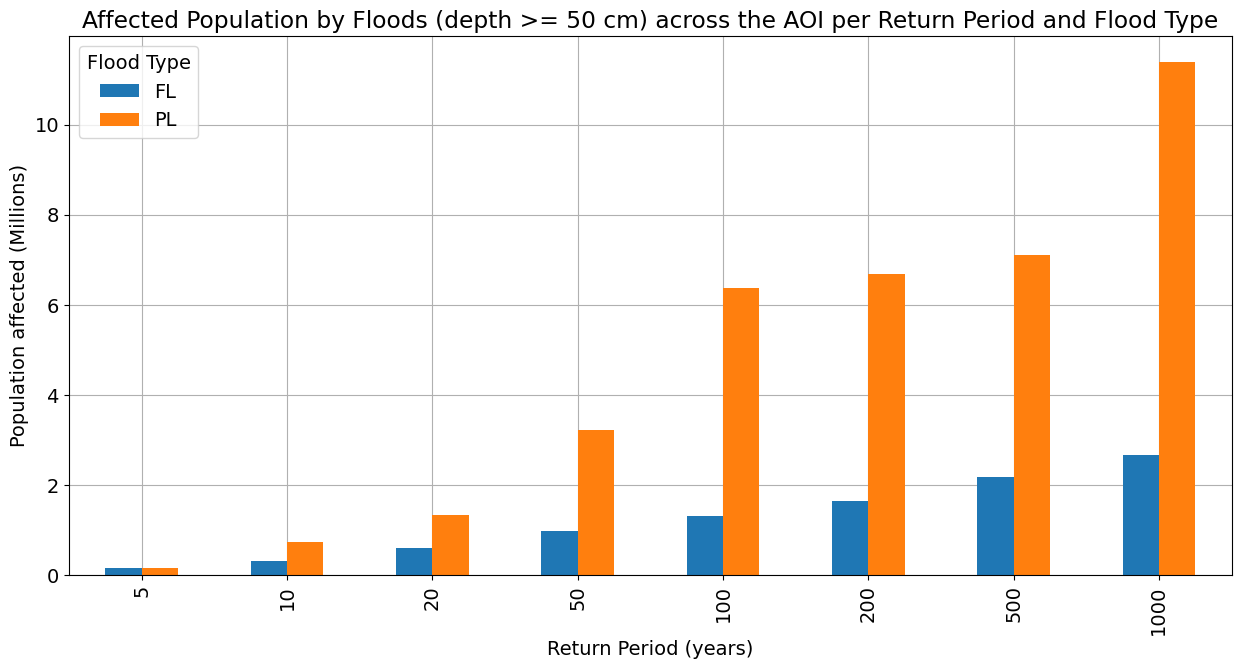

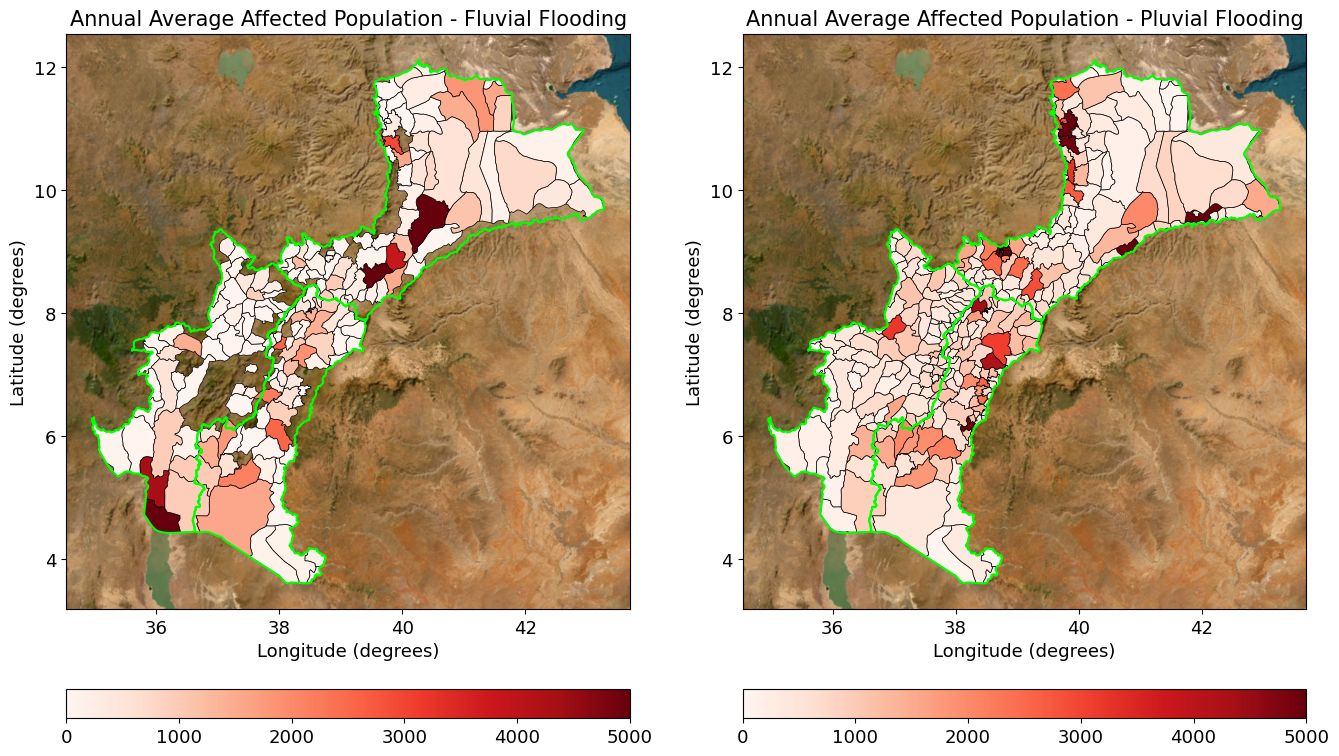

In [255]:
## Affected Population per event for whole AOI

df = df_risk_admin.sort_values(by='rp').reset_index(drop=True)
df['rp'] = df['rp'].astype(int)
df_pivot = df.pivot_table(index='rp', columns=['floodtype'], values='popcounts_flooded', aggfunc='sum')
 
# Plot Population affected per scenario
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(figsize=(15,7))

(df_pivot / 1e6).plot(ax=ax, kind='bar', zorder=2)
ax.set_xlabel('Return Period (years)')
ax.set_ylabel('Population affected (Millions)')
ax.legend(title='Flood Type', labels=['FL', 'PL'])
ax.set_title('Affected Population by Floods (depth >= 50 cm) across the AOI per Return Period and Flood Type')
ax.grid()

plt.savefig('/Users/aprida/Documents/Consulting/Public_sector/WB_Ethiopia/presentations/figures/pop_affected_per_event.jpeg', format='jpeg', dpi=300, bbox_inches='tight')

## Spatial distribution of the Annual Average Affected Population for Fluvial and Pluvial Flooding per Woreda

tablename = 'eth_wb_pol'
query = f"""
select *
from {tablename}
"""
gdf_basins = gpd.read_postgis(query, con, geom_col='geometry')

plt.rcParams['font.size'] = 13

fig, (ax1, ax2) = plt.subplots(figsize=(16,9), ncols=2, nrows=1)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="5%", pad=0.8)
gdf_merge.plot(ax=ax1, column='fluvial', cmap='Reds', legend=True, cax=cax, legend_kwds={"orientation": "horizontal"}, vmin=0, vmax=5000, edgecolor='black', linewidth=0.5)
gdf_basins.boundary.plot(ax=ax1, edgecolor='lime')
cx.add_basemap(ax=ax1, crs=4326, source=cx.providers.Esri.WorldImagery, attribution=False)
ax1.set_title(label='Annual Average Affected Population - Fluvial Flooding', fontsize=15)
ax1.set_xlabel('Longitude (degrees)')
ax1.set_ylabel('Latitude (degrees)')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("bottom", size="5%", pad=0.8)
gdf_merge.plot(ax=ax2, column='pluvial', cmap='Reds', legend=True, cax=cax, legend_kwds={"orientation": "horizontal"}, vmin=0, vmax=5000, edgecolor='black', linewidth=0.5)
gdf_basins.boundary.plot(ax=ax2, edgecolor='lime')
cx.add_basemap(ax=ax2, crs=4326, source=cx.providers.Esri.WorldImagery, attribution=False)
ax2.set_title(label='Annual Average Affected Population - Pluvial Flooding', fontsize=15)
ax2.set_xlabel('Longitude (degrees)')
ax2.set_ylabel('Latitude (degrees)')

print(f"""
Annual Average Affected Population by Floods, for Fluvial and Pluvial Flooding:\n
{pd.DataFrame(gdf_merge[['fluvial', 'pluvial']].sum()).T.to_markdown()}\n
""")
    
plt.savefig('/Users/aprida/Documents/Consulting/Public_sector/WB_Ethiopia/presentations/figures/aaap_eth_wb.jpeg', format='jpeg', dpi=300)

## Annual Average Affected Population for most affected Woredas

gdf_sel_fluvial = gdf_merge.sort_values(by='fluvial', ascending=False).reset_index(drop=True)[:20]
gdf_sel_fluvial.set_index('woredaname', inplace=True)
gdf_sel_pluvial = gdf_merge.sort_values(by='pluvial', ascending=False).reset_index(drop=True)[:20]
gdf_sel_pluvial.set_index('woredaname', inplace=True)

plt.rcParams['font.size'] = 15
fig, (ax1, ax2) = plt.subplots(figsize=(20,5), ncols=2, nrows=1)
bars1 = gdf_sel_fluvial[['fluvial']].plot(ax=ax1, kind='bar', zorder=2, legend=False)
ax1.set_title(label='Annual Average Affected Population per Woreda - Fluvial Flooding', fontsize=15)
ax1.set_xlabel('Woreda')
ax1.set_ylabel('Population')
ax1.grid()

# Annotate bars for fluvial flooding
for bar, annotation in zip(bars1.patches, round(gdf_sel_fluvial['aaap_pct_fl']*100, 1)):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,  # X position of the text
        height,                             # Y position of the text (top of the bar)
        f'{annotation}',                    # Text to display
        ha='center',                        # Horizontal alignment
        va='bottom'                         # Vertical alignment
    )


bars2 = gdf_sel_pluvial[['pluvial']].plot(ax=ax2, kind='bar', zorder=2, legend=False)
ax2.set_title(label='Annual Average Affected Population per Woreda - Pluvial Flooding', fontsize=15)
ax2.set_xlabel('Woreda')
ax2.set_ylabel('Population')
ax2.grid()

# Annotate bars for fluvial flooding
for bar, annotation in zip(bars2.patches, round(gdf_sel_pluvial['aaap_pct_pl']*100, 1)):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2,  # X position of the text
        height,                             # Y position of the text (top of the bar)
        f'{annotation}',                    # Text to display
        ha='center',                        # Horizontal alignment
        va='bottom'                         # Vertical alignment
    )


plt.savefig('/Users/aprida/Documents/Consulting/Public_sector/WB_Ethiopia/presentations/figures/aaap_eth_wb_main_affected_woredas.jpeg', format='jpeg', dpi=300, bbox_inches='tight')

In [112]:
# Overlay with Basin polygons

tablename_risk_basin = 'aaa_pop_eth_wb_admin3_basin'
tablename_risk = 'aaa_pop_eth_wb_admin3'
tablename_basins = 'eth_wb_pol'
query = f"""
drop table if exists {tablename_risk_basin};
create table {tablename_risk_basin} as
	with tmp as (
	select
		st_area(r.geometry::geography) as area_original_sqm, r.pluvial, r.fluvial, r.regionname, r.zonename, r.woredaname,
		b."BASIN_NAME" as basin_name,
		st_intersection(r.geometry, b.geometry) as geometry
	from
		{tablename_risk} as r,
		{tablename_basins} as b
	where
		st_intersects(r.geometry, b.geometry)
	)
	select
		tmp.area_original_sqm, tmp.pluvial, tmp.fluvial, tmp.regionname, tmp.zonename, tmp.woredaname, tmp.basin_name,
		st_area(tmp.geometry::geography) as area_intersection_basin_sqm,
		st_area(tmp.geometry::geography) / tmp.area_original_sqm * tmp.pluvial as popcounts_flooded_pluvial,
		st_area(tmp.geometry::geography) / tmp.area_original_sqm * tmp.fluvial as popcounts_flooded_fluvial,
		tmp.geometry
	from tmp;
"""

with con.connect() as connection:
    connection.execute(text(query))
    connection.commit()

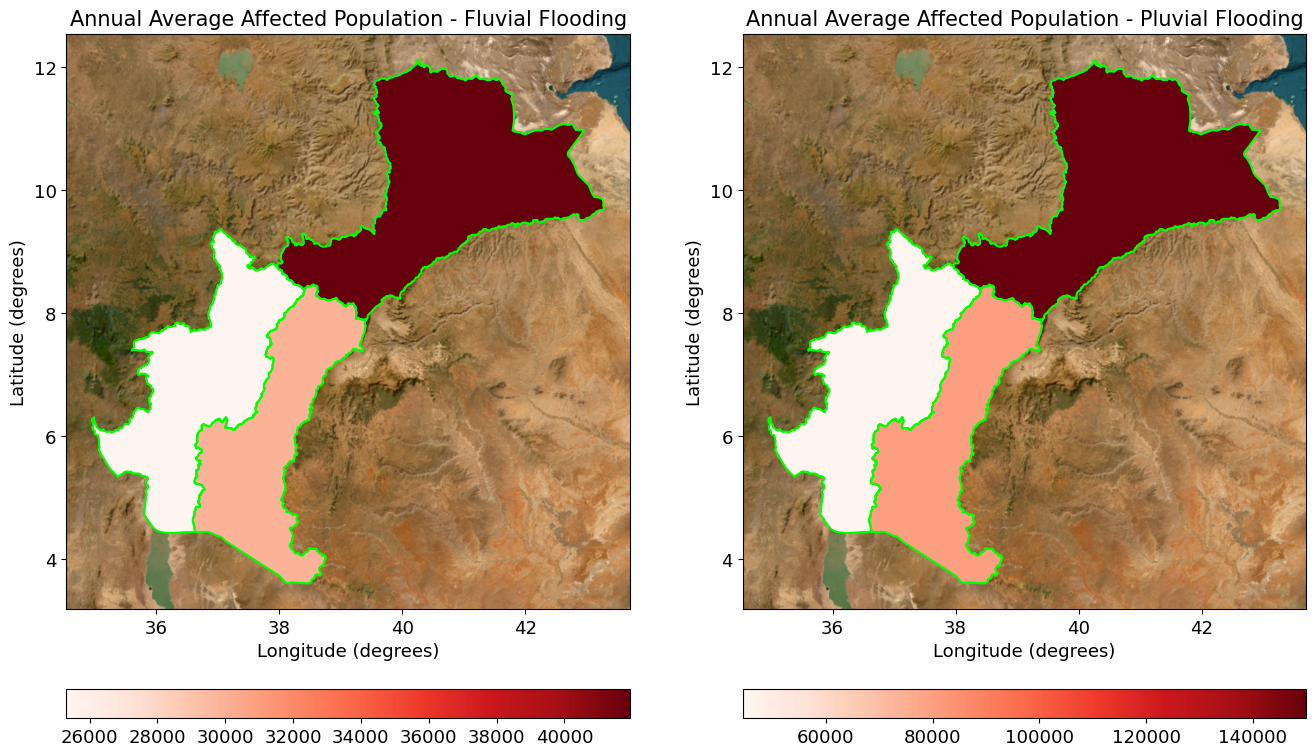

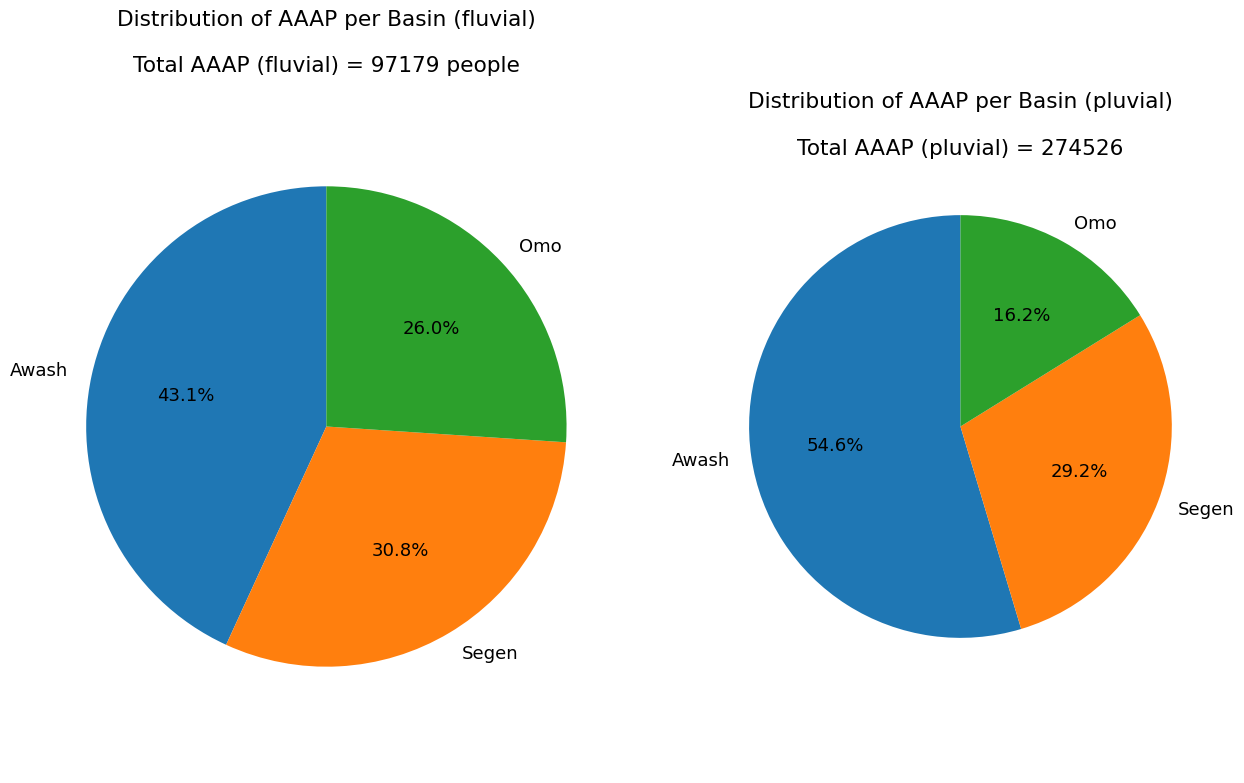

In [22]:
tablename = 'output_pop_risk_eth_wb_admin_basin'
query = f"""
select *
from {tablename}
"""

gdf_risk_basins = gpd.read_postgis(query, con, geom_col='geometry')
gdf_risk_basins = gdf_risk_basins.pivot_table(values=['popcounts_flooded_pluvial', 'popcounts_flooded_fluvial'], index='basin_name', aggfunc='sum')
gdf_risk_basins


tablename = 'eth_wb_pol'
query = f"""
select *
from {tablename}
"""
gdf_basins = gpd.read_postgis(query, con, geom_col='geometry')
gdf_basins.rename(columns={'BASIN_NAME': 'basin_name'}, inplace=True)
gdf_risk_basins = pd.merge(gdf_basins, gdf_risk_basins, on='basin_name')


# Plot annual average population affected, as agregated per basin

plt.rcParams['font.size'] = 13

fig, (ax1, ax2) = plt.subplots(figsize=(16,9), ncols=2, nrows=1)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="5%", pad=0.8)
gdf_risk_basins.plot(ax=ax1, column='popcounts_flooded_fluvial', cmap='Reds', legend=True, cax=cax, legend_kwds={"orientation": "horizontal"}, vmin=gdf_risk_basins['popcounts_flooded_fluvial'].min(), vmax=gdf_risk_basins['popcounts_flooded_fluvial'].max(), edgecolor='black', linewidth=0.5)
gdf_basins.boundary.plot(ax=ax1, edgecolor='lime')
cx.add_basemap(ax=ax1, crs=4326, source=cx.providers.Esri.WorldImagery, attribution=False)
ax1.set_title(label='Annual Average Affected Population - Fluvial Flooding', fontsize=15)
ax1.set_xlabel('Longitude (degrees)')
ax1.set_ylabel('Latitude (degrees)')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("bottom", size="5%", pad=0.8)
gdf_risk_basins.plot(ax=ax2, column='popcounts_flooded_pluvial', cmap='Reds', legend=True, cax=cax, legend_kwds={"orientation": "horizontal"}, vmin=gdf_risk_basins['popcounts_flooded_pluvial'].min(), vmax=gdf_risk_basins['popcounts_flooded_pluvial'].max(), edgecolor='black', linewidth=0.5)
gdf_basins.boundary.plot(ax=ax2, edgecolor='lime')
cx.add_basemap(ax=ax2, crs=4326, source=cx.providers.Esri.WorldImagery, attribution=False)
ax2.set_title(label='Annual Average Affected Population - Pluvial Flooding', fontsize=15)
ax2.set_xlabel('Longitude (degrees)')
ax2.set_ylabel('Latitude (degrees)')

plt.savefig('/Users/aprida/Documents/Consulting/Public_sector/WB_Ethiopia/presentations/figures/aaap_eth_wb_basins.jpeg', format='jpeg', dpi=300, bbox_inches='tight')

# Pie chart to show distribution of AAAP per basin
total_aaap_fl = round(gdf_risk_basins['popcounts_flooded_fluvial'].sum())
total_aaap_pl = round(gdf_risk_basins['popcounts_flooded_pluvial'].sum())

# Creating the pie chart
fig, (ax1, ax2) = plt.subplots(figsize=(15,9), ncols=2, nrows=1)
ax1.pie(gdf_risk_basins['popcounts_flooded_fluvial'], labels=gdf_risk_basins['basin_name'], autopct='%1.1f%%', startangle=90)
ax1.set_title(f'Distribution of AAAP per Basin (fluvial)\n\nTotal AAAP (fluvial) = {total_aaap_fl} people')
ax2.pie(gdf_risk_basins['popcounts_flooded_pluvial'], labels=gdf_risk_basins['basin_name'], autopct='%1.1f%%', startangle=90)
ax2.set_title(f'Distribution of AAAP per Basin (pluvial)\n\nTotal AAAP (pluvial) = {total_aaap_pl}')


# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')

plt.savefig('/Users/aprida/Documents/Consulting/Public_sector/WB_Ethiopia/presentations/figures/aaap_eth_wb_basins_piechart.jpeg', format='jpeg', dpi=300, bbox_inches='tight')

In [118]:
tablename = 'aaa_bld_eth_wb_admin3_basin'
query = f"""
select *
from {tablename}
"""

gdf_risk_basins = gpd.read_postgis(query, con, geom_col='geometry')
gdf = gdf_risk_basins.pivot_table(index=['basin_name', 'regionname', 'zonename', 'woredaname'], values=['buildings_flooded_pluvial', 'buildings_flooded_fluvial'], aggfunc='sum')
gdf = gdf.round(0)
fn = '/Users/aprida/Desktop/fra_eth_wb_bld.csv'
gdf.to_csv(fn)

In [119]:
tablename = 'aaa_bld_eth_wb_admin3'
query = f"""
select *
from {tablename}
"""

gdf_risk_basins = gpd.read_postgis(query, con, geom_col='geometry')

In [120]:
fn = '/Users/aprida/Desktop/woreda_pop.csv'
round(gdf_risk_basins[['regionname', 'zonename', 'woredaname', 'buildings_admin']]).to_csv(fn)